# Predicting ocean density from $\delta^{18}O$

Here we show how you can use this repository to predict ocean density from oxygen isotope composition of calcium carbonate shells of surface water foraminifera, $\delta^{18}O_c$. We will use the published data from marine sediment core SO188-KL342 in the Indian Ocean ([Weldeab et al. (2022)](https://doi.org/10.1016/j.epsl.2021.117327)).


## Import packages

First we import the necessary packages.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from models import predict_sigmaT
from utils.datasets import load_dataset

sns.set_style("darkgrid")

## Load data

Next, we load the dataset from Weldeab et al. (2022) which is stored in this respository and can be loaded using the `load_data` function.

In [2]:
data = load_dataset("weldeab")
data.head()

,d18Oc_mean,d18Oc_stdev,T_mean,T_stdev
age,,,,
350,-2.93,0.035,27.96,0.65
730,-3.07,0.035,29.47,0.65
1100,-3.22,0.035,28.05,0.65
1480,-3.41,0.035,28.17,0.65
1860,-3.20,0.035,28.64,0.65


Let's have a look at the data by plotting the $\delta^{18}O_c$ values against the their age.

Text(0.5, 1.0, 'd18Oc from sediment core SO188-KL342 (Indian Ocean)')

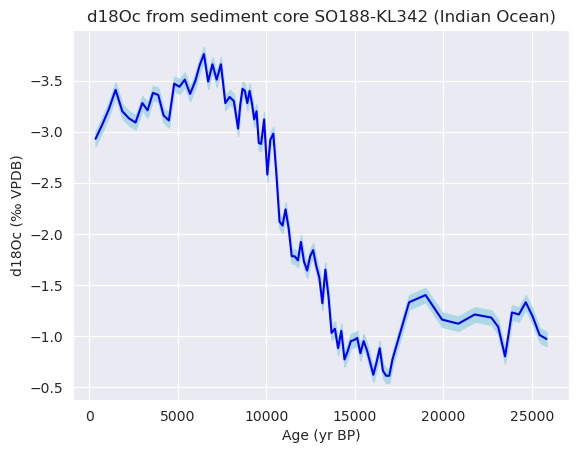

In [3]:
ax = plt.axes()
ax.fill_between(
    data.index,
    data["d18Oc_mean"] - 2 * data["d18Oc_stdev"],
    data["d18Oc_mean"] + 2 * data["d18Oc_stdev"],
    color="lightblue"
)
ax.plot(data.index, data["d18Oc_mean"], color="blue")
ax.invert_yaxis()
ax.set_xlabel("Age (yr BP)")
ax.set_ylabel("d18Oc (‰ VPDB)")
ax.set_title("d18Oc from sediment core SO188-KL342 (Indian Ocean)")

## Model predictions

To predict the surface density $\sigma_T$ from $\delta^{18}O_c$ we can use the `predict_sigmaT` function. There are just a few things that we have to provide for that:

- The `data` argument is the dataset that we loaded above.
- The `model` that we want to use. There are four models available:
   1. Linear model (`"Linear"`)
   2. Quadratic model (`"Poly2"`)
   3. Linear model with eigenvector spatial filtering (ESF) (`"LinearESF"`)
   4. Quadratic model with ESF (`"Poly2ESF"`)
- The column names in the `data` that contain the $\delta^{18}O_c$ mean values and the corresponding standard deviations (`name_d18Oc` and `name_d18Oc_stdev`).
- Optional: In case you want to use a spatial model (`"LinearESF"` or `"Poly2ESF"`) you have to provide the `lat` and `lon` columns in the `data` that contain the latitude and longitude of the core location.

Let's start with the quadratic model with ESF. For this we need to provide latitude and longitude of the core location so that the model can take spatial autocorrelation into account when predicting $\sigma_T$. The core is located at 19°58.41'N/90°02.03'E. We don't have to be over-precice here, so we just use 20°N/90°E.

In [4]:
data["lat"] = 20.0
data["lon"] = 90.0

Now we're ready to predict $\sigma_T$ from $\delta^{18}O_c$.

In [5]:
sT_esf = predict_sigmaT(
    X=data, 
    model="Poly2ESF",
    name_d18Oc="d18Oc_mean", 
    name_d18Oc_stdev="d18Oc_stdev",
    name_lon="lon",
    name_lat="lat"
)
sT_esf


/home/nrieger/miniconda3/envs/paleo/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [sigmaT, x_est]


<xarray.DataArray 'sigmaT' (d18Oc: 94, sample: 8000)>
array([[20.98727141, 19.82599665, 20.17875108, ..., 19.6481888 ,
        19.94456029, 19.12716301],
       [20.31592516, 19.58112856, 19.65306638, ..., 19.31906337,
        19.03589372, 19.61546998],
       [19.92808402, 19.72982545, 20.03198278, ..., 19.18015198,
        20.3725204 , 19.35922137],
       ...,
       [21.00053351, 20.77229009, 22.29904597, ..., 20.60438424,
        21.30124318, 20.94378428],
       [21.58495287, 21.69276436, 21.88133651, ..., 20.94091484,
        21.26310204, 21.47184841],
       [22.61731225, 20.58430325, 22.46569657, ..., 21.4780467 ,
        20.92863168, 22.01470196]])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * d18Oc    (d18Oc) float64 -2.93 -3.07 -3.22 -3.41 ... -1.33 -1.19 -1.01 -0.97

Note that the `predict_sigmaT` function returns a `xarray.DataArray` with the predicted $\sigma_T$ values sampled from the posterior distribution of the model. For visualization, let's convert the `d18Oc` dimension to `age` and plot the predicted $\sigma_T$ quantiles against the age.

In [6]:
sT_esf = sT_esf.rename({"d18Oc": "age"}).assign_coords({"age": data.index.values})
qs_esf = sT_esf.quantile([0.025, 0.25, 0.5, 0.75, 0.975], dim="sample")


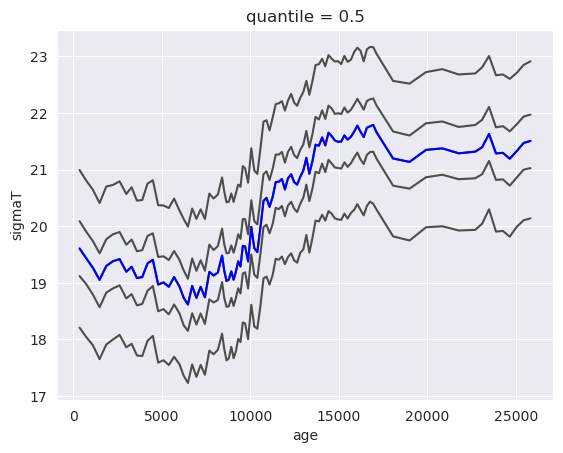

In [7]:
qs_esf.plot.line(x="age", color='.3', add_legend=False)
qs_esf.sel(quantile=0.5).plot(x="age", color="b", label="median")

## Saving the posterior distributions
To store all samples from the posterior distribution, the `netcdf` format is a natural choice:

In [8]:
sT_esf.reset_index("sample").to_netcdf("output/sigmaT_predicted.nc")

However, if you prefer to save the quantiles of the posterior distribution, we can easily convert it to a `pandas.DataFrame` and save it as a `csv` file:

In [9]:
df = qs_esf.to_dataframe().reset_index().pivot(index="age", columns="quantile", values="sigmaT")
df.head()

quantile,0.025,0.250,0.500,0.750,0.975
age,,,,,
350,18.207234,19.118482,19.606237,20.089222,20.993455
730,18.039117,18.974891,19.431745,19.901190,20.804720
1100,17.897503,18.792666,19.266183,19.739536,20.646449
1480,17.649911,18.567645,19.051676,19.520835,20.410103
1860,17.908985,18.826575,19.297646,19.770437,20.701353


In [10]:
df.to_csv("output/sigmaT_predicted.csv")

## Comparison to non-spatial predictions

Let's do the same for the quadratic model without ESF.

In [11]:
sT = predict_sigmaT(
    X=data, 
    model="Poly2",
    name_d18Oc="d18Oc_mean", 
    name_d18Oc_stdev="d18Oc_stdev",
    name_lon="lon",
    name_lat="lat"
)
sT = sT.rename({"d18Oc": "age"}).assign_coords({"age": data.index.values})
qs = sT.quantile([0.025, 0.25, 0.5, 0.75, 0.975], dim="sample")

/home/nrieger/miniconda3/envs/paleo/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [sigmaT, x_est]


Before we plot both prediction together let's first get a reference value. We can use the modern $\sigma_T$ values from the [World Ocean Atlas](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl?parameter=I) for that. We can use the `get_sigmaT_WOA` function to get the $\sigma_T$ values for the core location.

In [12]:
def get_sigmaT_WOA18(lon, lat):
    with xr.open_dataset("data/density/woa18_density_sigmaT_1981-2010.nc") as sT:
        return sT.sel(lon=lon, lat=lat, method="nearest", drop=True)

sigmaT_woa18 = get_sigmaT_WOA18(lon=90, lat=20)


Now we're ready to plot the predicted $\sigma_T$ values together with the reference value.

Text(0.5, 1.0, 'Predicted $\\sigma_T$ for marine sediment core SO188-KL342 (Indian Ocean)')

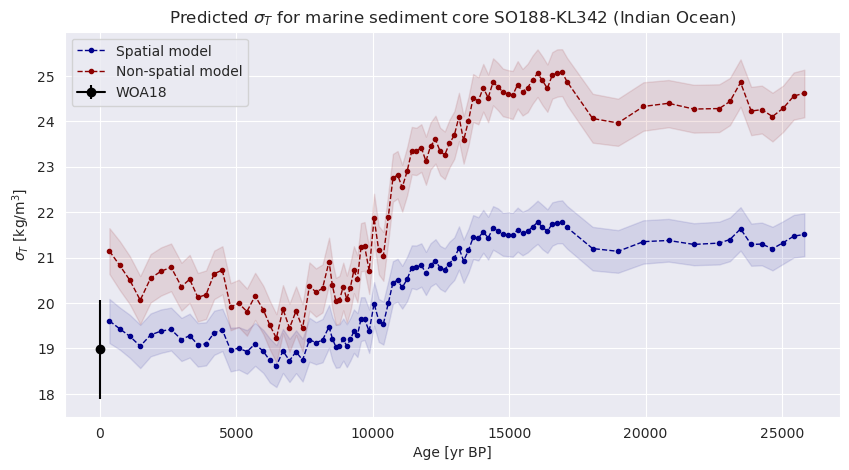

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# Spatial model
ax.fill_between(
    qs_esf.age,
    qs_esf.sel(quantile=0.25),
    qs_esf.sel(quantile=0.75),
    color="darkblue",
    alpha=0.1,
)
qs_esf.sel(quantile=0.5).plot(
    x="age", ax=ax, color="darkblue", marker=".", ls="--", lw=1, label="Spatial model"
)
# Non-spatial model
ax.fill_between(
    qs.age,
    qs.sel(quantile=0.25),
    qs.sel(quantile=0.75),
    color="darkred",
    alpha=0.1,
)
qs.sel(quantile=0.5).plot(
    x="age",
    ax=ax,
    color="darkred",
    marker=".",
    ls="--",
    lw=1,
    label="Non-spatial model",
)
ax.errorbar(
    0,
    sigmaT_woa18["mu"],
    yerr=sigmaT_woa18["sigma"],
    color="k",
    marker="o",
    label="WOA18",
)
ax.set_xlabel("Age [yr BP]")
ax.set_ylabel("$\sigma_T$ [kg/m$^3$]")
ax.legend()
ax.set_title("Predicted $\sigma_T$ for marine sediment core SO188-KL342 (Indian Ocean)")


We see that the quadratic model with ESF predicts a $\sigma_T$ value that is closer to the reference value than the quadratic model without ESF. This is because the quadratic model without ESF does not take spatial autocorrelation into account and therefore exhibits a larger bias. Additional benefit on including the spatial information through ESF is that the uncertainty of the prediction is reduced.

For example, the standard deviation for the most recent prediction of the quadratic model with ESF is ~0.6 $kg/m^3$ while it is 0.77 $kg/m^3$ for the quadratic model without ESF.

In [14]:
stdev_with_ESF = sT_esf.isel(age=0).std().item()
stdev_no_ESF = sT.isel(age=0).std().item()
print(f"Standard deviation with ESF: {stdev_with_ESF:.2f}")
print(f"Standard deviation without ESF: {stdev_no_ESF:.2f}")

Standard deviation with ESF: 0.71
Standard deviation without ESF: 0.76
